# DeepSTARR Training

In [1]:
# adapted from Deepstarr colab notebook: https://colab.research.google.com/drive/1Xgak40TuxWWLh5P5ARf0-4Xo0BcRn0Gd 

import sys
import time
import sklearn
import json
import tensorflow as tf
import keras
import keras_nlp
import keras.layers as kl
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras_nlp.layers import SinePositionEncoding, TransformerEncoder
from keras.layers import BatchNormalization
from keras.models import Sequential, Model, load_model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, History, ModelCheckpoint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from collections import Counter
from itertools import product
from sklearn.metrics import mean_squared_error

2024-12-07 20:20:18.739393: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-07 20:20:19.165694: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-07 20:20:19.236793: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-07 20:20:21.529426: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-07 20:20:29.125821: W tensorflow/comp

In [2]:
startTime=time.time()

In [3]:
def LoadConfig(config):
    with open(config, 'r') as file:
        params = json.load(file)
    return params

In [4]:
def one_hot_encode(seq):
    nucleotide_dict = {'A': [1, 0, 0, 0],
                       'C': [0, 1, 0, 0],
                       'G': [0, 0, 1, 0],
                       'T': [0, 0, 0, 1],
                       'N': [0, 0, 0, 0]} 
    return np.array([nucleotide_dict[nuc] for nuc in seq])

In [5]:
def kmer_encode(sequence, k=3):
    sequence = sequence.upper()
    kmers = [sequence[i:i+k] for i in range(len(sequence) - k + 1)]
    kmer_counts = Counter(kmers)
    return {kmer: kmer_counts.get(kmer, 0) / len(kmers) for kmer in [''.join(p) for p in product('ACGT', repeat=k)]}

def kmer_features(seq, k=3):
    all_kmers = [''.join(p) for p in product('ACGT', repeat=k)]
    feature_matrix = []
    kmer_freqs = kmer_encode(seq, k)
    feature_vector = [kmer_freqs[kmer] for kmer in all_kmers]
    feature_matrix.append(feature_vector)
    return np.array(feature_matrix)

In [6]:
def prepare_input(data_set, params):
    if params['encode'] == 'one-hot':
        seq_matrix = np.array(data_set['Sequence'].apply(one_hot_encode).tolist())  # (number of sequences, length of sequences, nucleotides)
    elif params['encode'] == 'k-mer':
        seq_matrix = np.array(data_set['Sequence'].apply(kmer_features, k=3).tolist())  # (number of sequences, 1, 4^k)
    else:
        raise Exception ('wrong encoding method')

    Y_dev = data_set.Dev_log2_enrichment
    Y_hk = data_set.Hk_log2_enrichment
    Y = [Y_dev, Y_hk]

    return seq_matrix, Y

In [7]:
def DeepSTARR(params):
    if params['encode'] == 'one-hot':
        input = kl.Input(shape=(249, 4)) 
    elif params['encode'] == 'k-mer':
        input = kl.Input(shape=(1, 64)) 

    for i in range(params['convolution_layers']['n_layers']):
        x = kl.Conv1D(params['convolution_layers']['filters'][i],
                      kernel_size = params['convolution_layers']['kernel_sizes'][i],
                      padding = params['pad'],
                      name=str('Conv1D_'+str(i+1)))(input)
        x = kl.BatchNormalization()(x)
        x = kl.Activation('relu')(x)
        if params['encode'] == 'one-hot':
            x = kl.MaxPooling1D(2)(x)

        if params['dropout_conv'] == 'yes': x = kl.Dropout(params['dropout_prob'])(x)

    # optional attention layers
    for i in range(params['transformer_layers']['n_layers']):
        if i == 0:
            x = x + keras_nlp.layers.SinePositionEncoding()(x)
        x = TransformerEncoder(intermediate_dim = params['transformer_layers']['attn_key_dim'][i],
                                num_heads = params['transformer_layers']['attn_heads'][i],
                                dropout = params['dropout_prob'])(x)
    
    # After the convolutional layers, the output is flattened and passed through a series of fully connected/dense layers
    # Flattening converts a multi-dimensional input (from the convolutions) into a one-dimensional array (to be connected with the fully connected layers
    x = kl.Flatten()(x)
    
    # Fully connected layers
    # Each fully connected layer is followed by batch normalization, ReLU activation, and dropout
    for i in range(params['n_dense_layer']):
        x = kl.Dense(params['dense_neurons'+str(i+1)],
                     name=str('Dense_'+str(i+1)))(x)
        x = kl.BatchNormalization()(x)
        x = kl.Activation('relu')(x)
        x = kl.Dropout(params['dropout_prob'])(x)
    
    # Main model bottleneck
    bottleneck = x
    
    # heads per task (developmental and housekeeping enhancer activities)
    # The final output layer is a pair of dense layers, one for each task (developmental and housekeeping enhancer activities), each with a single neuron and a linear activation function
    tasks = ['Dev', 'Hk']
    outputs = []
    for task in tasks:
        outputs.append(kl.Dense(1, activation='linear', name=str('Dense_' + task))(bottleneck))
    
    # Build Keras model object
    model = Model([input], outputs)
    model.compile(Adam(learning_rate=params['lr']), # Adam optimizer
                  loss=['mse', 'mse'], # loss is Mean Squared Error (MSE)
                  loss_weights=[1, 1]) # in case we want to change the weights of each output. For now keep them with same weights

    return model, params

In [8]:
def train(selected_model, X_train, Y_train, X_valid, Y_valid, params):
    my_history=selected_model.fit(X_train, Y_train,
                                  validation_data=(X_valid, Y_valid), 
                                  batch_size=params['batch_size'],
                                  epochs=params['epochs'],
                                  callbacks=[EarlyStopping(patience=params['early_stop'], monitor="val_loss", restore_best_weights=True), History()])

    return selected_model, my_history

In [9]:
def summary_statistics(X, Y, set, task, main_model, main_params):
    pred = main_model.predict(X, batch_size=main_params['batch_size']) # predict
    if task =="Dev":
        i=0
    if task =="Hk":
        i=1
    print(set + ' MSE ' + task + ' = ' + str("{0:0.2f}".format(mean_squared_error(Y, pred[i].squeeze()))))
    print(set + ' PCC ' + task + ' = ' + str("{0:0.2f}".format(stats.pearsonr(Y, pred[i].squeeze())[0])))
    print(set + ' SCC ' + task + ' = ' + str("{0:0.2f}".format(stats.spearmanr(Y, pred[i].squeeze())[0])))

In [10]:
def my_scatter_density(X, Y, set, task, main_model, main_params, label):
    pred = main_model.predict(X, batch_size=main_params['batch_size'])
    if task =="Dev":
        i=0
        c="red"
    if task =="Hk":
        i=1
        c="blue"

    g = sns.jointplot(x=Y, y=pred[i].squeeze(), kind="kde", fill=True, color=c)
    g.ax_marg_x.remove() # remove marginal densities
    g.ax_marg_y.remove() # remove marginal densities

    # add regression line of data
    # sns.regplot(x=Y, y=pred[i].squeeze(), scatter=False, color='black', ax=g.ax_joint)

    # add expected regression line
    x0, x1 = g.ax_joint.get_xlim()
    y0, y1 = g.ax_joint.get_ylim()
    lims = [max(x0, y0), min(x1, y1)]
    g.ax_joint.plot(lims, lims, 'w', linestyle='dashed', transform=g.ax_joint.transData, color='grey')

    # same axes ranges
    g.ax_joint.set_aspect('equal')

    PCC = str("{0:0.2f}".format(stats.pearsonr(Y, pred[i].squeeze())[0]))
    plt.xlabel('Measured expression [log2]')
    plt.ylabel('Predicted expression [log2]')
    plt.title(str(task + ' - ' + set + ' set (PCC=' + PCC + ')'))
    plt.show()
    # plt.savefig(outdir + '/' + label + '-' + set + '-' + task + '.png')


In [11]:
def main(config, indir, outdir, label):
    data = pd.read_table(indir)
    params = LoadConfig(config)

    X_train, Y_train = prepare_input(data[data['set'] == "Train"], params)
    X_valid, Y_valid = prepare_input(data[data['set'] == "Val"], params)
    X_test, Y_test = prepare_input(data[data['set'] == "Test"], params)

    DeepSTARR(params)[0].summary() 
    DeepSTARR(params)[1] 
    main_model, main_params = DeepSTARR(params)
    main_model, my_history = train(main_model, X_train, Y_train, X_valid, Y_valid, main_params)

    endTime=time.time()
    seconds=endTime-startTime
    print("Total training time:",round(seconds/60,2),"minutes")

    summary_statistics(X_train, Y_train[0], "train", "Dev", main_model, main_params)
    summary_statistics(X_valid, Y_valid[0], "validation", "Dev", main_model, main_params)
    summary_statistics(X_test, Y_test[0], "test", "Dev", main_model, main_params)

    summary_statistics(X_train, Y_train[1], "train", "Hk", main_model, main_params)
    summary_statistics(X_valid, Y_valid[1], "validation", "Hk", main_model, main_params)
    summary_statistics(X_test, Y_test[1], "test", "Hk", main_model, main_params)

    my_scatter_density(X_test, Y_test[0], "test", "Dev", main_model, main_params, label)
    my_scatter_density(X_test, Y_test[1], "test", "Hk", main_model, main_params, label)

    main_model.save(outdir + '/' + label + '.h5')


I0000 00:00:1733620877.850201 2341958 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733620885.129892 2341958 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733620885.133508 2341958 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733620885.137134 2341958 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 249, 4)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1D_4 (Conv1D)   │ (None, 249, 128)  │     32,896 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 249, 128)  │        512 │ Conv1D_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 249, 128)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_3     │ (None, 124, 128)  │          0 │ activation_3[0][… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 124, 128)  │          0 │ max_pooling1d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 15872)     │          0 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dense_1 (Dense)     │ (None, 64)        │  1,015,872 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ Dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 64)        │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 64)        │          0 │ activation_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dense_Dev (Dense)   │ (None, 1)         │         65 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dense_Hk (Dense)    │ (None, 1)         │         65 │ dropout_4[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,049,666 (4.00 MB)

 Trainable params: 1,049,282 (4.00 MB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/100


/opt/conda/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_56']. Received: the structure of inputs=*
  warnings.warn(
I0000 00:00:1733620895.054675 2342009 service.cc:146] XLA service 0x7f41e8011d50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733620895.054743 2342009 service.cc:154]   StreamExecutor device (0): NVIDIA RTX 5000 Ada Generation, Compute Capability 8.9
2024-12-07 20:21:35.223350: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-07 20:21:35.905596: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


  85/6286 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - Dense_Dev_loss: 3.3706 - Dense_Hk_loss: 5.1625 - loss: 8.5331 

I0000 00:00:1733620906.283984 2342009 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


6286/6286 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Dense_Dev_loss: 2.2568 - Dense_Hk_loss: 2.7343 - loss: 4.9911

/opt/conda/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_56']. Received: the structure of inputs=*
  warnings.warn(


6286/6286 ━━━━━━━━━━━━━━━━━━━━ 27s 2ms/step - Dense_Dev_loss: 2.2567 - Dense_Hk_loss: 2.7343 - loss: 4.9910 - val_Dense_Dev_loss: 1.9490 - val_Dense_Hk_loss: 2.3270 - val_loss: 4.2763
Epoch 2/100
6286/6286 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - Dense_Dev_loss: 1.9694 - Dense_Hk_loss: 2.2271 - loss: 4.1965 - val_Dense_Dev_loss: 1.8985 - val_Dense_Hk_loss: 2.1791 - val_loss: 4.0779
Epoch 3/100
6286/6286 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - Dense_Dev_loss: 1.9135 - Dense_Hk_loss: 2.0725 - loss: 3.9860 - val_Dense_Dev_loss: 1.9005 - val_Dense_Hk_loss: 2.1192 - val_loss: 4.0200
Epoch 4/100
6286/6286 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - Dense_Dev_loss: 1.8835 - Dense_Hk_loss: 1.9543 - loss: 3.8379 - val_Dense_Dev_loss: 1.8483 - val_Dense_Hk_loss: 2.0088 - val_loss: 3.8573
Epoch 5/100
6286/6286 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - Dense_Dev_loss: 1.8464 - Dense_Hk_loss: 1.8658 - loss: 3.7122 - val_Dense_Dev_loss: 1.8320 - val_Dense_Hk_loss: 1.9325 - val_loss: 3.7647
Epoch 6/100
6286/6286 ━━━━━━━━━━

/tmp/ipykernel_2341958/1480100958.py:21: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "w" (-> color=(1.0, 1.0, 1.0, 1)). The keyword argument will take precedence.
  g.ax_joint.plot(lims, lims, 'w', linestyle='dashed', transform=g.ax_joint.transData, color='grey')


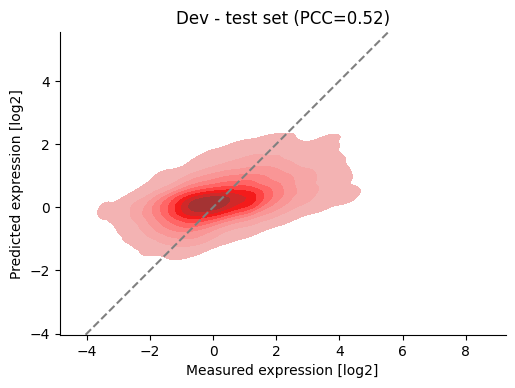

644/644 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


/tmp/ipykernel_2341958/1480100958.py:21: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "w" (-> color=(1.0, 1.0, 1.0, 1)). The keyword argument will take precedence.
  g.ax_joint.plot(lims, lims, 'w', linestyle='dashed', transform=g.ax_joint.transData, color='grey')


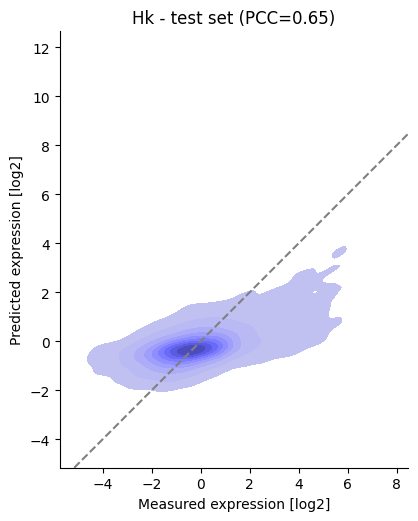

In [12]:
# model architecture of optimal model
main('/hpc/home/yc583/Biostat-823/Final_Project/config/config-conv-117.json',
     '/hpc/home/yc583/Biostat-823/Final_Project/data/Sequences_activity_all.txt', 
     '/hpc/home/yc583/Biostat-823/Final_Project/saved_models',
     'conv-117')